In [3]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy import stats
from multiprocessing import Pool
import os
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import NearestNeighbors

## Load processed data and predicted cell types

In [6]:
'load data'
tpm_log = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/tpm_merge_log.csv',index_col=0)  

In [7]:
'load prediction'
prediction = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/patch_seq_prediction.csv',index_col=0)     
prediction.index = [ item.split('X')[1] for item in prediction.index]

In [8]:
EPSC_cells = ['O12301','021804','021805','021806','021808','030301','030704','030705',
             '030706','030709','031001','031003','031004','031007','031008','031101',
             '032101','032102','032103',
             '033003','033004','033102','033104','033105','033106','033107','033110']
cells = np.intersect1d(prediction.index,EPSC_cells).tolist() + prediction.loc[prediction['predicted.id'] == '0'].index.tolist() + prediction.loc[prediction['predicted.id'] == '1'].index.tolist() + prediction.loc[prediction['predicted.id'] == 'Treg'].index.tolist()  
tpm_log = tpm_log[cells]


In [12]:
umap = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/Tumor_only/UMAP.csv',index_col=0)

## Load anchors

In [ ]:
anchors = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/patch_EPSC_anchors.csv',index_col=0)
anchors_name = pd.DataFrame(columns=anchors.columns,index=anchors.index)

cell_rank = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/patch_EPSC_seq_prediction.csv',index_col=0)   
cell_rank.index = [ item.split('X')[1] for item in cell_rank.index]

anchor_ranking = pd.read_csv('/home/qukun/ccp1997/GBM_10X/patch_seq/batch3/anchor_ranking.csv',index_col=0)

for item in anchors.index:
    anchors_name.loc[item] = [anchor_ranking.index[int(anchors.loc[item]['cell1'] - 1)],cell_rank.index[int(anchors.loc[item]['cell2'] - 1)],anchors.loc[item]['score']]

anchors_cells = pd.DataFrame(index = list(set(anchors_name['cell2'])),columns=['anchor_cell'])
for cell in anchors_cells.index:
    result = anchors_name.loc[anchors_name['cell2'] == cell].loc[anchors_name.loc[anchors_name['cell2'] == cell]['score'] == np.max(anchors_name.loc[anchors_name['cell2'] == cell]['score'])]['cell1'].tolist() 
    anchors_cells.loc[cell]['anchor_cell'] = result

In [12]:
select_cells = []
for cell in anchors_cells.index:
    if len(np.intersect1d(anchors_cells.loc[cell]['anchor_cell'],umap.index)) != 0:
        select_cells.append(cell)

In [13]:
anchors_cells = anchors_cells.loc[select_cells]
other_cells = pd.DataFrame(index=np.setdiff1d(cell_rank.index,anchors_cells.index),columns=['anchor_cell'])

## KNN for cells without anchor cells

In [33]:
for cell in other_cells.index:
    
    for_knn = tpm_log[cell_rank.index]

    for_knn = for_knn[np.setdiff1d(for_knn.columns,other_cells.index).tolist() + [cell]]

    for_knn = for_knn.loc[np.sum(for_knn,axis=1) != 0]

    X = np.array(for_knn.T.values)
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree',n_jobs=20).fit(X)
    knn_results = nbrs.kneighbors_graph(X).toarray()
    knn_results = pd.DataFrame(knn_results,index=for_knn.columns,columns=for_knn.columns)

    tmp_result = anchors_cells.loc[np.setdiff1d(knn_results.columns[knn_results.loc[cell] == 1],cell)]

    #other_cells.loc[cell]['anchor_cell'] = list(np.union1d(tmp_result.iloc[0]['anchor_cell'],tmp_result.iloc[1]['anchor_cell']))
    other_cells.loc[cell]['anchor_cell'] = list(tmp_result.iloc[0]['anchor_cell'])

## Generate UMAP

In [1354]:
UMAP_1 = []
UMAP_2 = []
for cell in anchors_cells.index:
    UMAP_1.append(np.mean(umap.loc[np.intersect1d(anchors_cells.loc[cell][0],umap.index)])['UMAP_1'] + ((1-(-1))*np.random.random() + (-1))*0.2)
    UMAP_2.append(np.mean(umap.loc[np.intersect1d(anchors_cells.loc[cell][0],umap.index)])['UMAP_2'] + ((1-(-1))*np.random.random() + (-1))*0.2)
anchors_cells['UMAP_1'] = UMAP_1
anchors_cells['UMAP_2'] = UMAP_2

In [1355]:
UMAP_1 = []
UMAP_2 = []
for cell in other_cells.index:
    UMAP_1.append(np.mean(umap.loc[np.intersect1d(other_cells.loc[cell][0],umap.index)])['UMAP_1'] + ((1-(-1))*np.random.random() + (-1))*0.2) 
    UMAP_2.append(np.mean(umap.loc[np.intersect1d(other_cells.loc[cell][0],umap.index)])['UMAP_2'] + ((1-(-1))*np.random.random() + (-1))*0.2) 
other_cells['UMAP_1'] = UMAP_1
other_cells['UMAP_2'] = UMAP_2

In [1356]:
merge_umap = pd.concat([anchors_cells,other_cells])

## Plot

In [1357]:
meta_data = pd.read_csv('/home/qukun/ccp1997/GBM_10X/In_depth/scRNA_matrix/meta_data.csv',index_col=0)

In [1358]:
clust_colors = {'4':'#17728C','2':'#00AECF','14':'#C1EDF6','1':'#C5E5BD','0':'#89CFC5','7':'#AA5FAC','9':'#748EBF','12':'#00C8FB','18':'#B43826','15':'#F01F1A','10':'#AE958C','16':'#FF3D73',\
                'MES':'#C6008D','AC':'#FED100','PN':'#00B055',\
                'neuron':'#4C7A66',\
                'B cells':'#ECD157',\
                'Treg':'#fc912a','T-IFI6':'#FF6666','T-CDKN2A':'#CE9A68',\
                'cytotoxic CD8T':'#FD9DC6','exhausted CD8T':'#eedce4',\
                'memory CD4T':'#FFB3A1','T-HSPA1A':'#FFD9CE'}    

umap['cluster'] = meta_data.loc[umap.index]['anno']
clust_color_list = [ clust_colors[item]  for item in umap['cluster']]
umap['cluster_color'] = clust_color_list

In [1360]:
PN_cells = umap.loc[umap['cluster'] == 'PN'].index.tolist()
MES_AC_cells = umap.loc[umap['cluster'] != 'PN'].index.tolist()

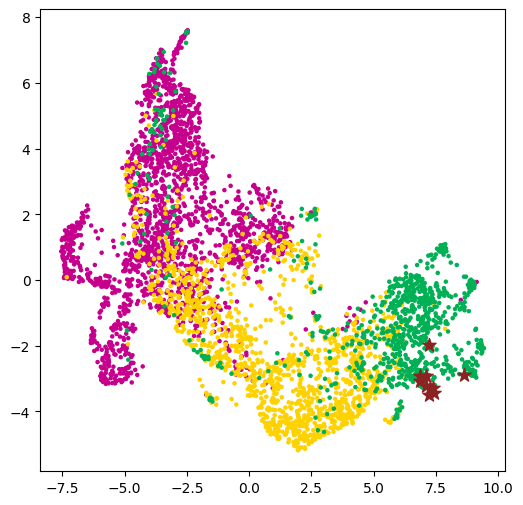

In [1368]:
plt.figure(figsize=(6,6))
plt.scatter(x=umap['UMAP_1'],y=umap['UMAP_2'],c=umap['cluster_color'],s=5,rasterized=True)
plt.scatter(x=merge_umap['UMAP_1'],y=merge_umap['UMAP_2'],s=100,color='#8B2323',marker='*')
plt.savefig('/home/qukun/ccp1997/GBM_10X/In_depth/figure/result_5/patch_seq_umap_10_cells.pdf',dpi=500)      